<a href="https://colab.research.google.com/github/nsarker-git/Particle_Swarm_Optimization/blob/main/Image_Classification_using_ConvenNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setp- up Environment
Model : ConvNext
To load custom image folder: A pytorch library called "ImageFolder documentation: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

In [1]:
!pip install -q transformers datasets

     |████████████████████████████████| 4.7 MB 31.9 MB/s 
     |████████████████████████████████| 365 kB 69.6 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
     |████████████████████████████████| 6.6 MB 58.6 MB/s 
     |████████████████████████████████| 596 kB 42.8 MB/s 
     |████████████████████████████████| 141 kB 71.5 MB/s 
     |████████████████████████████████| 115 kB 53.4 MB/s 
     |████████████████████████████████| 212 kB 18.1 MB/s 
     |████████████████████████████████| 127 kB 69.1 MB/s 


## Load dataset

In [2]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/Colab Notebooks/Data/Images")


Resolving data files:   0%|          | 0/862 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-a103e075996166fc/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
#checking the dataset dictionary
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 862
    })
})

In [4]:
#checking the classes and labels 
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=2, names=['Magnoliopsida', 'Pinopsida'], id=None)}

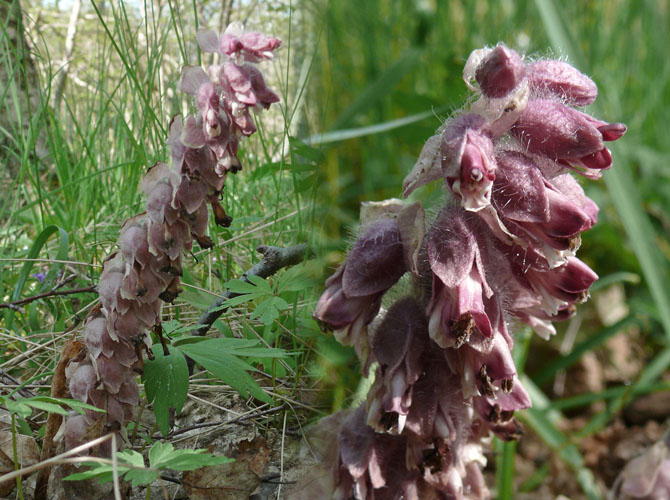

In [5]:
example= dataset["train"][2]
example["image"]

In [6]:
#printing the image class label
#but we it is in numaric format, so we need to map the label nomber to class name
example["label"]

0

In [7]:
90# store labels
labels = dataset["train"].features["label"].names
print(labels)

['Magnoliopsida', 'Pinopsida']


#Mapping ID to Label

In [8]:
id2label = {k:v for k,v in enumerate(labels)}
#for machine's sake convert back to number
label2id = {v:k for v,k in enumerate(labels)}
print(label2id)

{0: 'Magnoliopsida', 1: 'Pinopsida'}


In [9]:
id2label[0]

'Magnoliopsida'

## Push dataset to Hub


In [10]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [12]:
dataset.push_to_hub("nsarker/plantspecies-demo")

  0%|          | 0/1 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1951: FutureWarning: `identical_ok` has no effect and is deprecated. It will be removed in 0.11.0.
  FutureWarning,


In [13]:
from datasets.load import load_dataset_builder
#accessing from different computer
from datasets import load_dataset
reloaded_dataset = load_dataset("nsarker/plantspecies-demo")

Downloading:   0%|          | 0.00/839 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nsarker___parquet/nsarker--plantspecies-demo-172ea773e0c7be8d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## Process the image dataset
Convnext is a CNN inspired by Resnest and Transformer. 
Feature Extractor: prepare image for the model
In this case: convnext-tiny-224 selected for fine tuning for this dataset used by Facebook. 
We also need to load the corresponding feature extractor.

In [14]:
from transformers import ConvNextFeatureExtractor

In [15]:
#Not a typical pretrained model, only download the JSON file
feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

In [16]:
#check the configuration 
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



# Data Augmentation

## For this project torchvision from Pytorch used for transforming and aumenting the images
Documentation:https://pytorch.org/vision/stable/index.html

Feature extraction: Normalization
## Using Compose Operator(a class) to provide a list of transformations such as Crop to resize to 224 and flip

In [17]:
from torchvision.transforms.transforms import RandomResizedCrop
#tochvision already built-in in colab
# feature extraction: Normalization

from torchvision.transforms import(
    Compose,
    Normalize,
    RandomHorizontalFlip,
    ToTensor
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
transform  = Compose(
    (
    RandomResizedCrop(feature_extractor.size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize
        
    )

)
# define a custom function to apply on entire dataset

def train_transforms(examples):
  examples["pixel_values"]= [transform(image.convert("RGB")) for image in examples["image"]]

  return examples


In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 862
    })
})

# Now it's time to apply the image transformation on entire dataset, since the total image number is only 882, so 100 batchsize is chosen. The default batchsize is 1000

In [ ]:
transformed_dataset = dataset.map(train_transforms, batched=100)

Note that the above process may take time for large dataset. So, alternatively, we are going to apply image augmentation on they fly, means we will use "**image transformation**" only when it is needed for the model. but not on the **ENTIRE DATASET**

In [19]:
# apply image transformation on the fly - Alternative approch of map
processed_dataset = dataset.with_transform(train_transforms)

In [20]:
processed_dataset["train"][100]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=670x500 at 0x7F8623B9A210>,
 'label': 0,
 'pixel_values': tensor([[[-1.9980, -1.9980, -2.0152,  ..., -1.2103, -1.2103, -1.1932],
          [-1.9980, -1.9980, -2.0152,  ..., -1.1247, -1.1760, -1.1589],
          [-1.9980, -1.9980, -2.0152,  ..., -1.0390, -1.1075, -1.1418],
          ...,
          [-0.4739, -0.3369,  0.1939,  ...,  0.5022,  0.4679,  0.3652],
          [-0.2342, -0.1828,  0.2111,  ...,  0.5193,  0.4337,  0.2967],
          [ 0.1254, -0.0458,  0.1768,  ...,  0.5022,  0.3994,  0.2796]],
 
         [[-1.8606, -1.8606, -1.8606,  ..., -1.0728, -1.0903, -1.0903],
          [-1.8606, -1.8606, -1.8606,  ..., -1.0203, -1.0553, -1.0553],
          [-1.8606, -1.8606, -1.8606,  ..., -0.9853, -1.0203, -1.0203],
          ...,
          [ 0.1527,  0.2577,  0.5553,  ...,  0.7654,  0.6954,  0.6779],
          [ 0.3452,  0.3803,  0.5903,  ...,  0.7304,  0.6429,  0.6078],
          [ 0.7129,  0.5203,  0.6078,  ...,  0.7129, 

In [21]:
# checking the image pixel values
# torch Size(color channel- 3(RGB), pixel size 224 by 224)
processed_dataset["train"][100]["pixel_values"].shape

torch.Size([3, 224, 224])

#Define Model
Now it's time to fine-tune the checkpoint for the model. With the help of Auto Class, in this model using "AutoModelForImageClassification" that automatically instantiate the correct class.

## ConvNext Tiny 224 checkpoint:
According to Documentation: ConvNeXT (tiny-sized model)
Link: https://huggingface.co/facebook/convnext-tiny-224#convnext-tiny-sized-model

**Model description**
ConvNeXT is a pure convolutional model (ConvNet), inspired by the design of Vision Transformers, that claims to outperform them. The authors started from a ResNet and "modernized" its design by taking the Swin Transformer as inspiration.

In [22]:
labels

['Magnoliopsida', 'Pinopsida']

In [23]:
len(labels)

2

In [24]:
#import the class from transformers module
from transformers import AutoModelForImageClassification

#providing the checkpoint(with the help of Auto API) we will fine-tune
#to re-initialize the model, pre-trained weights has been ignored by using argumnet: ignore_mistamch_sizes
model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True
                                                        )

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Move to GPU

In [ ]:
import torch 
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

In [29]:
# the train set contains three columns: image, label and pixel_values
processed_dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=667x500 at 0x7F854182EED0>,
 'label': 0,
 'pixel_values': tensor([[[ 0.2111,  0.3823,  0.4337,  ..., -2.0152, -1.9980, -1.9638],
          [ 0.0227,  0.2796,  0.3994,  ..., -1.9809, -1.9809, -1.9467],
          [-0.0801,  0.1768,  0.3309,  ..., -1.9809, -1.9809, -1.9809],
          ...,
          [-1.9467, -1.9638, -1.9809,  ..., -0.7993, -0.7993, -0.7993],
          [-1.9467, -1.9638, -1.9638,  ..., -0.7993, -0.8164, -0.8164],
          [-1.9638, -1.9467, -1.9638,  ..., -0.8335, -0.7822, -0.7822]],
 
         [[ 0.3627,  0.5028,  0.5378,  ..., -1.9132, -1.8957, -1.8606],
          [ 0.1702,  0.3978,  0.5028,  ..., -1.8782, -1.8782, -1.8431],
          [ 0.0651,  0.2927,  0.4503,  ..., -1.8782, -1.8782, -1.8782],
          ...,
          [-1.7731, -1.7906, -1.8081,  ..., -0.2150, -0.2150, -0.2150],
          [-1.7731, -1.7906, -1.7906,  ..., -0.2150, -0.2325, -0.2325],
          [-1.7906, -1.7731, -1.7906,  ..., -0.2500, 

In [32]:
# we need to delete some columns
from torch.utils.data import DataLoader
def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for exmaple in examples])
  return {"pixel_values": pixel_values, "labels": labels}

dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=4, shuffle=True) 

In [33]:
#checking if the above code properly worked by printing what every batch is containing
#it suppossed to show "batch size", "color channel", "pixel size" as per the model expects as forward
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# Train the Model: :)

In [34]:
#checking if the corrent GPU found
device

'cuda'

In [35]:
#for more details about GPU spec provided by google
!nvidia-smi

Fri Aug 12 15:38:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    30W /  70W |    738MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
#to track training progress
from tqdm.notebook import tqdm

#select the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(10):
  print("Epoch:", epoch)
  correct = 0
  total = 0
  for idx, batch in enumerate(tqdm(dataloader)):
    #move batch to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    #forward pass
    outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])
    
    loss = outputs.loss
    loss.backward()
    optimizer.step()

   # print("Loss:", loss.items()) 

    #metrics
    total += batch["labels"].shape[0]
    predicted = outputs.logits.argmax(-1)
    correct +=(predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"acuuracy after {idx} steps:", accuracy)




Epoch: 0


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 1


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 2


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 3


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 4


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 5


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 6


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 7


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 8


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0
Epoch: 9


  0%|          | 0/216 [00:00<?, ?it/s]

Loss after 0 steps: 0.0
acuuracy after 0 steps: 1.0
Loss after 100 steps: 0.0
acuuracy after 100 steps: 1.0
Loss after 200 steps: 0.0
acuuracy after 200 steps: 1.0


## push to hub

In [39]:
repo_name = "nsarker/convnext-tiny-finetune-plantspecies"
model.push_to_hub(repo_name)
feature_extractor.push_to_hub(repo_name)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='convnext-tiny-finetune-plantspecies' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:644: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/nsarker/convnext-tiny-finetune-plantspecies into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/106M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/nsarker/convnext-tiny-finetune-plantspecies
   6a02c3d..16dcd25  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/nsarker/convnext-tiny-finetune-plantspecies
   6a02c3d..16dcd25  main -> main

To https://huggingface.co/nsarker/convnext-tiny-finetune-plantspecies
   16dcd25..4843f90  main -> main

   16dcd25..4843f90  main -> main



'https://huggingface.co/nsarker/convnext-tiny-finetune-plantspecies/commit/4843f90bcac1463c3dcbd6c28eb66b1c219d6669'

## Inference 
Load the model back again from hugguing face HUb

In [40]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification 
feature_extractor = AutoFeatureExtractor.from_pretrained("nsarker/convnext-tiny-finetune-plantspecies")
model = AutoModelForImageClassification.from_pretrained("nsarker/convnext-tiny-finetune-plantspecies")

In [ ]:
#import a test image from web
from PIL import Image
import requests

url = "https://content.eol.org/data/media/c9/fc/6d/537.43669e16e6c51d97ec2f8f768beab1ea.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

First resize the new test image

In [54]:
# resize the web image
pixel_values = feature_extractor(image.convert("RGB"), return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [55]:
import torch
# torch.no_grad is a context manager in python
with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [56]:
print(logits.shape)

torch.Size([1, 2])


In [57]:
predicted_class_idx = logits.argmax(-1).item()
print(model.config.id2label[predicted_class_idx])

Magnoliopsida
